## 1. Описание проекта

Задачей проекта является построение скоринг-модели для вторичных клиентов банка, которая бы предсказывала вероятность дефолта клиента.  
Для этого нужно определить значимые параметры заемщика.  
Результаты оцениваются по Mean F1-Score

In [1]:
# импортируем необходимые библиотеки

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score, cross_validate, GridSearchCV
from sklearn.metrics import mean_squared_error, f1_score, accuracy_score
from sklearn.metrics import balanced_accuracy_score, precision_recall_curve
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, auc
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder
from itertools import combinations, combinations_with_replacement

%matplotlib inline
import warnings
warnings.simplefilter('ignore')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/sf-scoring/sample_submission.csv
/kaggle/input/sf-scoring/train.csv
/kaggle/input/sf-scoring/test.csv


## 2. Сбор и знакомство с данными

In [2]:
# загружаем данные
DATA_DIR = '/kaggle/input/sf-scoring/'
df_train = pd.read_csv(DATA_DIR +'/train.csv')
df_test = pd.read_csv(DATA_DIR +'/test.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [3]:
print(f'shape of df_train: {df_train.shape}')
print(f'shape of df_test: {df_test.shape}')
print(f'shape of sample_submission: {sample_submission.shape}')

shape of df_train: (73799, 19)
shape of df_test: (36349, 18)
shape of sample_submission: (36349, 2)


In [4]:
df_train.tail()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
73794,54887,04MAR2014,GRD,F,45,N,N,0,0,-1.792064,3,50,1,2,17000,4,4,N,0
73795,76821,24MAR2014,SCH,M,41,Y,Y,0,0,-2.058029,1,50,2,2,70000,1,4,N,0
73796,103695,22APR2014,SCH,M,31,N,N,0,0,-1.512635,4,80,2,3,45000,2,2,N,0
73797,861,04JAN2014,SCH,F,29,N,N,0,1,-1.479334,3,50,1,3,13000,2,3,N,1
73798,15796,23JAN2014,GRD,M,34,N,N,0,0,-1.764711,2,50,2,3,25000,1,3,N,0


In [5]:
df_test.tail()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport
36344,83775,31MAR2014,SCH,F,37,N,N,1,0,-1.744976,3,50,2,3,15000,4,1,N
36345,106254,25APR2014,GRD,F,64,Y,Y,0,0,-2.293781,3,60,1,2,200000,1,4,N
36346,81852,30MAR2014,GRD,M,31,N,N,2,0,-0.940752,1,50,1,2,60000,4,2,N
36347,1971,07JAN2014,UGR,F,27,N,N,1,0,-1.242392,2,80,2,3,30000,1,1,N
36348,69044,17MAR2014,SCH,M,38,N,N,0,0,-1.507549,2,50,1,2,15000,4,2,N


In [6]:
sample_submission.tail()

,client_id,default
36344,83775,0
36345,106254,0
36346,81852,0
36347,1971,0
36348,69044,0


In [7]:
# проверим идентичность client_id в тестовой и submission выборках
(df_test.client_id == sample_submission.client_id).value_counts()

True    36349
Name: client_id, dtype: int64

In [8]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0  # помечаем где у нас тест
df_test['default'] = -1 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем невозможным значением -1

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем
data.shape

(110148, 20)

In [9]:
# Приглядимся, а что собственно за данные у нас есть
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

In [10]:
data.nunique(dropna=False)

client_id           110148
app_date               120
education                6
sex                      2
age                     52
car                      2
car_type                 2
decline_app_cnt         24
good_work                2
score_bki           102618
bki_request_cnt         40
region_rating            7
home_address             3
work_address             3
income                1207
sna                      4
first_time               4
foreign_passport         2
sample                   2
default                  3
dtype: int64

### Описание полей

- client_id - идентификатор клиента  
- app_date - дата подачи заявки
- education - уровень образования
- sex - пол
- age - возраст
- car - наличие автомобиля
- car_type - наличие определенного автомобиля, например стоимостью более 1 млн.руб.
- decline_app_cnt - количество отклоненных заявок
- good_work - наличия хорошей работы
- score_bki - скоринговый балл по данным из БКИ
- bki_request_cnt - количество запросов в БКИ
- region_rating - рейтинг региона
- home_address - категория домашнего адреса, например определенный район или удаленность от центра
- work_address - категория рабочего адреса, аналогично
- income - доход
- sna - связь заемщика с клиентами банка (что это значит, не представляю...)
- first_time - давность наличия информации о заемщике
- foreign_passport - наличие загранпаспорта
- default - флаг дефолта по кредиту (0 - "хороший клиент", 1 - "плохой клиент")

Доля неплатежеспособных заемщиков составляет 12.7% от общего количества наблюдений в обучающей выборке.



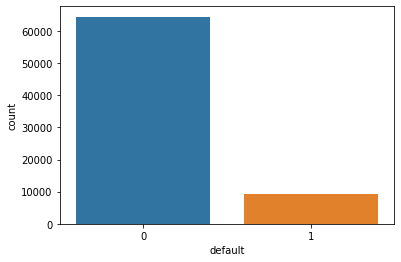

In [11]:
# посмотрим распределение целевой переменной в обучающей выборке
percentage = '{:.1f}%'.format(100*df_train['default'].sum()/len(df_train['default']))
print(f"Доля неплатежеспособных заемщиков составляет {percentage} от общего количества наблюдений в обучающей выборке.\n")
sns.countplot(x='default', data=df_train)
plt.show()

Специалисты данной области рекомендуют для построения скоринговых моделей использовать выборку с долей неплатежеспособных заемщиков не менее 5%.  
В нашем случае эта доля составляет 12,7%, это хорошо. Но в любом случае нужно учесть несбалансированность классов.

## 3. Очистка и предобработка данных

In [12]:
# посмотрим на пропуски
data.isna().sum()

client_id             0
app_date              0
education           478
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
sample                0
default               0
dtype: int64

Решим проблему с пропусками, когда доберемся до этого признака.

### 3.1 Client id

In [13]:
# проверим, есть ли дублирование данных по client id
print(f"Все клиенты уникальны: {data['client_id'].nunique() == data.shape[0]}")

Все клиенты уникальны: True


In [14]:
# проверим, является ли client_id ординальным признаком. Если да, то должен быть высоким коэф.корреляции с датой подачи заявок
# сначала обработаем признак app_date
data.app_date = pd.to_datetime(data.app_date)

2014-03-18    1491
2014-03-19    1363
2014-03-17    1350
2014-03-31    1317
2014-04-07    1296
              ... 
2014-04-20     359
2014-01-07     349
2014-01-03     313
2014-01-02     204
2014-01-01      56
Name: app_date, Length: 120, dtype: int64

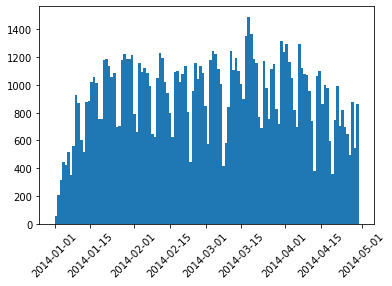

In [15]:
# проверим app_date на адекватность
data.app_date.hist(bins=data.app_date.nunique(), xrot=45, grid=False)
data.app_date.value_counts()

Выборосов или неадекватных временных меток не обнаружено. Все данные более менее равномерно распределены в промежутке с 1 января 2014 по 30 апреля 2014.  
Есть предположение, что в выходные дни количество заявок резко проседает.

In [16]:
data['ts'] = data['app_date'].astype('int64') // 10**9
data[['client_id','ts']].corr()

,client_id,ts
client_id,1.000000,0.999581
ts,0.999581,1.000000


Гипотеза об ординальности признака client_id и соответственно о тесной связи с app_date подтвердилась.  
Логической нагрузки признак client_id не несет, поэтому удалим его.

In [17]:
data.drop('client_id', axis=1, inplace=True)

### 3.2 App_date

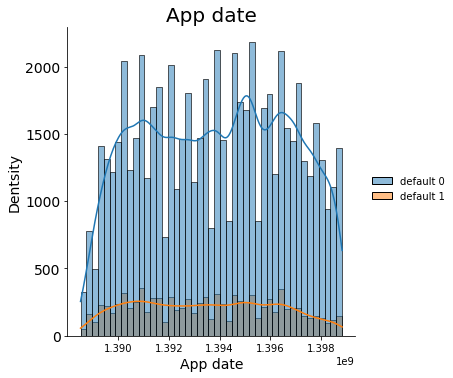

In [18]:
# интересно посмотреть, есть ли тенденция в количестве дефолтов в зависимости от времени
sns.displot({"default 0": data[data['default'] == 0].ts,
             "default 1": data[data['default'] == 1].ts,
             },
            kde=True,
            common_norm=True # независимая нормализация каждого подмножества
            )
plt.title('App date', fontsize=20)
plt.xlabel('App date', fontsize=14)
plt.ylabel('Dentsity', fontsize=14)
#plt.grid()

plt.xticks()
plt.yticks(fontsize=14);

Монотонного роста или падения количества дефолтов  зависимости от времени не наблюдается.  
Из признака app_date я выделю новые признаки: месяц, день недели и признак выходного дня.

In [19]:
data['app_month']=data['app_date'].dt.month
data['app_day_of_week']=data['app_date'].dt.day_of_week
data['app_is_day_off']=data['app_day_of_week'].apply(lambda x: 1 if x>4 else 0)

In [20]:
# признаки app_date и ts (timestamp) удалим
data.drop(['app_date','ts'], axis=1, inplace=True)

### 3.3 Education

In [21]:
data.education.unique()

array(['GRD', 'SCH', 'UGR', 'PGR', nan, 'ACD'], dtype=object)

SCH - school, школа, 8 классов

GRD - graduate, колледж, 10-12 классов

UGR - undergraduate, ВУЗ

PGR - postgraduate, аспирант

ACD - academy, профессор

In [22]:
data.education.value_counts(dropna=False)

SCH    57998
GRD    34768
UGR    14748
PGR     1865
NaN      478
ACD      291
Name: education, dtype: int64

In [23]:
# пропущенных значений относительно общего объема выборки не велик. Но с другой стороны, профессоров еще меньше.
# чтобы не потерять информацию о возможном осознанном утаивании оставим пропуски как еще одно значение данного признака
data.education.fillna("unknown", inplace=True)

### 3.4 Sex, car, car_type, foreign_passport

In [24]:
# преобразуем эти признаки в числовые для более удобной дальнейшей обработки
bin_cols = ['sex', 'car', 'car_type', 'foreign_passport']
le = LabelEncoder()
for col in bin_cols:
    data[col] = le.fit_transform(data[col])

In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   education         110148 non-null  object 
 1   sex               110148 non-null  int64  
 2   age               110148 non-null  int64  
 3   car               110148 non-null  int64  
 4   car_type          110148 non-null  int64  
 5   decline_app_cnt   110148 non-null  int64  
 6   good_work         110148 non-null  int64  
 7   score_bki         110148 non-null  float64
 8   bki_request_cnt   110148 non-null  int64  
 9   region_rating     110148 non-null  int64  
 10  home_address      110148 non-null  int64  
 11  work_address      110148 non-null  int64  
 12  income            110148 non-null  int64  
 13  sna               110148 non-null  int64  
 14  first_time        110148 non-null  int64  
 15  foreign_passport  110148 non-null  int64  
 16  sample            11

### 3.5 Age

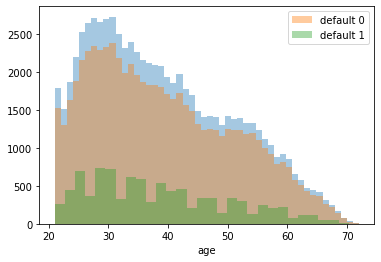

In [26]:
# построим графики распределения переменной возраст, общий и в разрезе целевой переменной
sns.distplot(data[data['sample'] == 1].age, kde=False)
sns.distplot(data[data.default == 0].age, kde=False, label='default 0')
sns.distplot(data[data.default == 1].age, kde=False, label='default 1')
plt.legend()
plt.show()

Видим логнормальное распределение. Выбросов нет.

## 4. Монотонный WOE binning переменных

In [27]:
# функция для биннинга категориальных и непрерывных переменных и вычисления WOE/IV
# честно заимствована отсюда https://www.listendata.com/2015/03/weight-of-evidence-woe-and-information.html
def iv_woe(data, target, bins=10, show_woe=False):
    '''Function calculates IV (Information value) and WoE (weight of evidence)
    for categorial and numeric features.'''    
        
    #Empty Dataframe
    newDF,woeDF = pd.DataFrame(), pd.DataFrame()
    
    #Extract Column Names
    cols = data.columns
    
    #Run WOE and IV on all the independent variables
    for ivars in cols[~cols.isin([target])]:
        if (data[ivars].dtype.kind in 'bifc') and (len(np.unique(data[ivars]))>bins):
            binned_x = pd.qcut(data[ivars], bins,  duplicates='drop')
            d0 = pd.DataFrame({'x': binned_x, 'y': data[target]})
        else:
            d0 = pd.DataFrame({'x': data[ivars], 'y': data[target]})
        d = d0.groupby("x", as_index=False).agg({"y": ["count", "sum"]})
        d.columns = ['Cutoff', 'N', 'Events']
        d['% of Events'] = np.maximum(d['Events'], 0.5) / d['Events'].sum()
        d['Non-Events'] = d['N'] - d['Events']
        d['% of Non-Events'] = np.maximum(d['Non-Events'], 0.5) / d['Non-Events'].sum()
        d['WoE'] = np.log(d['% of Events']/d['% of Non-Events'])
        d['IV'] = d['WoE'] * (d['% of Events'] - d['% of Non-Events'])
        d.insert(loc=0, column='Variable', value=ivars)
        #print("Information value of " + ivars + " is " + str(round(d['IV'].sum(),6)))
        temp =pd.DataFrame({"Variable" : [ivars], "IV" : [d['IV'].sum()]}, columns = ["Variable", "IV"])
        newDF=pd.concat([newDF,temp], axis=0)
        woeDF=pd.concat([woeDF,d], axis=0)

        #Show WOE Table
        if show_woe == True:
            print(d)
    newDF = newDF.sort_values(by='IV', ascending=False).reset_index(drop=True)
    woeDF.reset_index(drop=True, inplace=True)
    return newDF, woeDF

In [28]:
# функция для построения графиков категоризованных признаков и WOE
def plot_bin(woeDF, variable):
    tmp = woeDF[woeDF.Variable==variable]
    fig,ax = plt.subplots(figsize=(16,8), facecolor='w')
    ax.bar(tmp.Cutoff.astype(str), tmp.WoE)
    ax.plot(tmp.Cutoff.astype(str), tmp.WoE, color='r', label=variable)
    ax.yaxis.grid()
    plt.tight_layout()
    plt.legend()
    plt.show()

In [29]:
newDF, woeDF = iv_woe(data[data['sample']==1], 'default', bins=10, show_woe=False)

In [30]:
newDF

,Variable,IV
0,score_bki,0.275214
1,sna,0.132047
2,first_time,0.101243
3,region_rating,0.081816
4,home_address,0.079869
5,education,0.072655
6,work_address,0.067363
7,decline_app_cnt,0.065325
8,foreign_passport,0.048587
9,bki_request_cnt,0.044567


In [31]:
woeDF

,Variable,Cutoff,N,Events,% of Events,Non-Events,% of Non-Events,WoE,IV
0,education,ACD,194,8,0.000854,186,0.002887,-1.218499,0.002478
1,education,GRD,23365,2105,0.224605,21260,0.329986,-0.384706,0.040541
2,education,PGR,1257,81,0.008643,1176,0.018253,-0.747619,0.007185
3,education,SCH,38860,5852,0.624413,33008,0.512332,0.197840,0.022174
4,education,UGR,9816,1291,0.137751,8525,0.132320,0.040220,0.000218
...,...,...,...,...,...,...,...,...,...
83,app_day_of_week,4,11263,1351,0.144153,9912,0.153849,-0.065095,0.000631
84,app_day_of_week,5,8231,1078,0.115023,7153,0.111025,0.035382,0.000141
85,app_day_of_week,6,6750,872,0.093043,5878,0.091235,0.019624,0.000035
86,app_is_day_off,0,58818,7422,0.791933,51396,0.797740,-0.007306,0.000042


## 5. Отсев переменных по information value, ручной binning

Первое, что нужно сделать - отсеять признаки с IV < 0.02, при этом по возможности сохранить исходные данные.

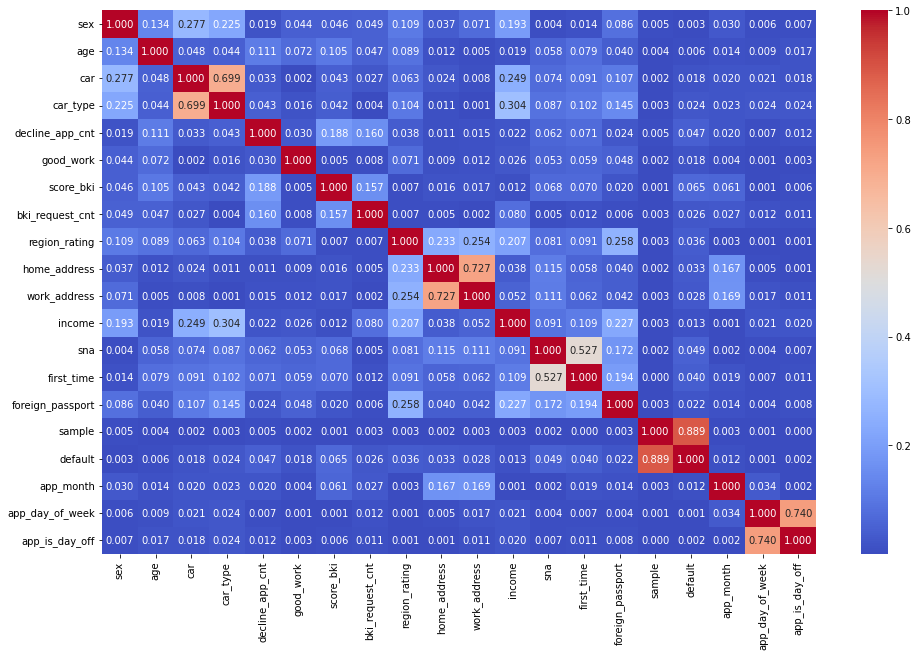

In [32]:
# Посмотрим на матрицу корреляций
plt.figure(figsize=(16, 10))
sns.heatmap(data.corr().abs(), annot=True, cmap='coolwarm', fmt='.3f', annot_kws={'size':10})
plt.show()

In [33]:
woeDF[woeDF.Variable.isin(['app_is_day_off','app_day_of_week'])]

,Variable,Cutoff,N,Events,% of Events,Non-Events,% of Non-Events,WoE,IV
79,app_day_of_week,0,12024,1528,0.163039,10496,0.162913,0.000772,9.706509e-08
80,app_day_of_week,1,12176,1551,0.165493,10625,0.164915,0.003496,2.019644e-06
81,app_day_of_week,2,11740,1459,0.155676,10281,0.159576,-0.024740,9.647285e-05
82,app_day_of_week,3,11615,1533,0.163572,10082,0.156487,0.044281,3.137394e-04
83,app_day_of_week,4,11263,1351,0.144153,9912,0.153849,-0.065095,6.311427e-04
84,app_day_of_week,5,8231,1078,0.115023,7153,0.111025,0.035382,1.414778e-04
85,app_day_of_week,6,6750,872,0.093043,5878,0.091235,0.019624,3.548123e-05
86,app_is_day_off,0,58818,7422,0.791933,51396,0.797740,-0.007306,4.242059e-05
87,app_is_day_off,1,14981,1950,0.208067,13031,0.202260,0.028305,1.643547e-04


In [34]:
# ввиду низкой предиктивной силы, высокой корреляции и исскуственной синтезации признаков 'app_is_day_off','app_day_of_week', удалим их
data.drop(['app_is_day_off','app_day_of_week', 'app_month'], axis=1, inplace=True)

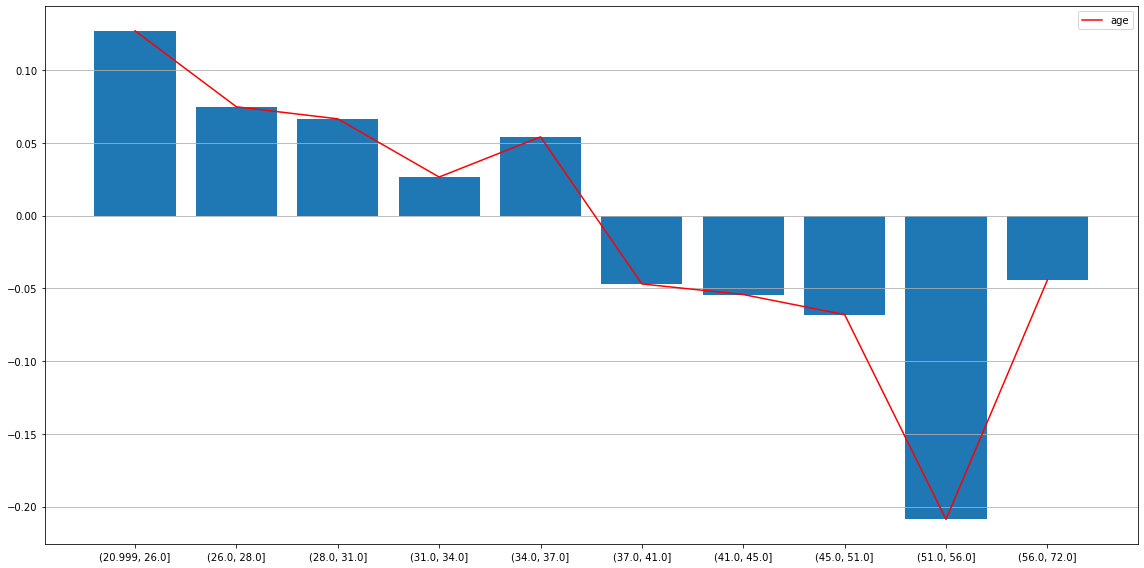

In [35]:
plot_bin(woeDF, 'age')

In [36]:
woeDF[woeDF.Variable=='age']

,Variable,Cutoff,N,Events,% of Events,Non-Events,% of Non-Events,WoE,IV
8,age,"(20.999, 26.0]",9898,1403,0.149701,8495,0.131855,0.126941,0.002265
9,age,"(26.0, 28.0]",5350,725,0.077358,4625,0.071787,0.074746,0.000416
10,age,"(28.0, 31.0]",8079,1087,0.115984,6992,0.108526,0.066461,0.000496
11,age,"(31.0, 34.0]",7210,937,0.099979,6273,0.097366,0.026480,0.000069
12,age,"(34.0, 37.0]",6536,870,0.092830,5666,0.087944,0.054061,0.000264
13,age,"(37.0, 41.0]",7959,970,0.103500,6989,0.108479,-0.046990,0.000234
14,age,"(41.0, 45.0]",6920,838,0.089415,6082,0.094401,-0.054264,0.000271
15,age,"(45.0, 51.0]",8342,998,0.106487,7344,0.113989,-0.068079,0.000511
16,age,"(51.0, 56.0]",6383,674,0.071916,5709,0.088612,-0.208763,0.003485
17,age,"(56.0, 72.0]",7122,870,0.092830,6252,0.097040,-0.044357,0.000187


In [37]:
data['binned_age'] = pd.cut(data.age, [20,26,37,51,72])

In [38]:
newDF, woeDF = iv_woe(data[data['sample']==1], 'default', bins=10, show_woe=False)
newDF

,Variable,IV
0,score_bki,0.275214
1,sna,0.132047
2,first_time,0.101243
3,region_rating,0.081816
4,home_address,0.079869
5,education,0.072655
6,work_address,0.067363
7,decline_app_cnt,0.065325
8,foreign_passport,0.048587
9,bki_request_cnt,0.044567


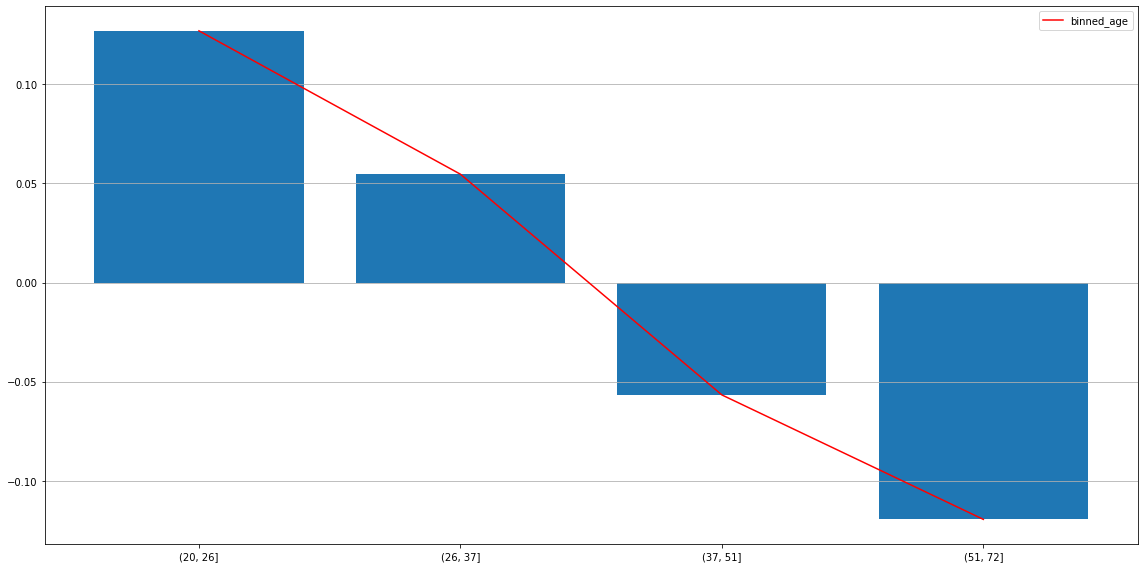

In [39]:
plot_bin(woeDF, 'binned_age')

In [40]:
woeDF[woeDF.Variable=='binned_age']

,Variable,Cutoff,N,Events,% of Events,Non-Events,% of Non-Events,WoE,IV
75,binned_age,"(20, 26]",9898,1403,0.149701,8495,0.131855,0.126941,0.002265
76,binned_age,"(26, 37]",27175,3619,0.386150,23556,0.365623,0.054623,0.001121
77,binned_age,"(37, 51]",23221,2806,0.299402,20415,0.316870,-0.056704,0.000990
78,binned_age,"(51, 72]",13505,1544,0.164746,11961,0.185652,-0.119469,0.002498


Есть линейная связь между binned_age и целевой переменной, но предсказательная сила очень мала

In [41]:
data.drop('age', axis=1, inplace=True)

Попробуем объединить признаки car и car_type в один

In [42]:
data.groupby('car').car_type.value_counts()

car  car_type
0    0           74290
1    1           21008
     0           14850
Name: car_type, dtype: int64

In [43]:
# просто сложим два признака.
data['mapped_car'] = data['car'] + data['car_type']

In [44]:
newDF, woeDF = iv_woe(data[data['sample']==1], 'default', bins=10, show_woe=False)
newDF

,Variable,IV
0,score_bki,0.275214
1,sna,0.132047
2,first_time,0.101243
3,region_rating,0.081816
4,home_address,0.079869
5,education,0.072655
6,work_address,0.067363
7,decline_app_cnt,0.065325
8,foreign_passport,0.048587
9,bki_request_cnt,0.044567


In [45]:
# отлично, признаки по отдельности удалим
data.drop(['car','car_type'], axis=1, inplace=True)

Проделаем ту же хитрость с адресами

In [46]:
data.groupby(['home_address'])['work_address'].value_counts().rename('count').reset_index()

,home_address,work_address,count
0,1,2,29066
1,1,1,11832
2,1,3,7790
3,2,3,57609
4,2,2,1574
5,2,1,408
6,3,3,1714
7,3,2,121
8,3,1,34


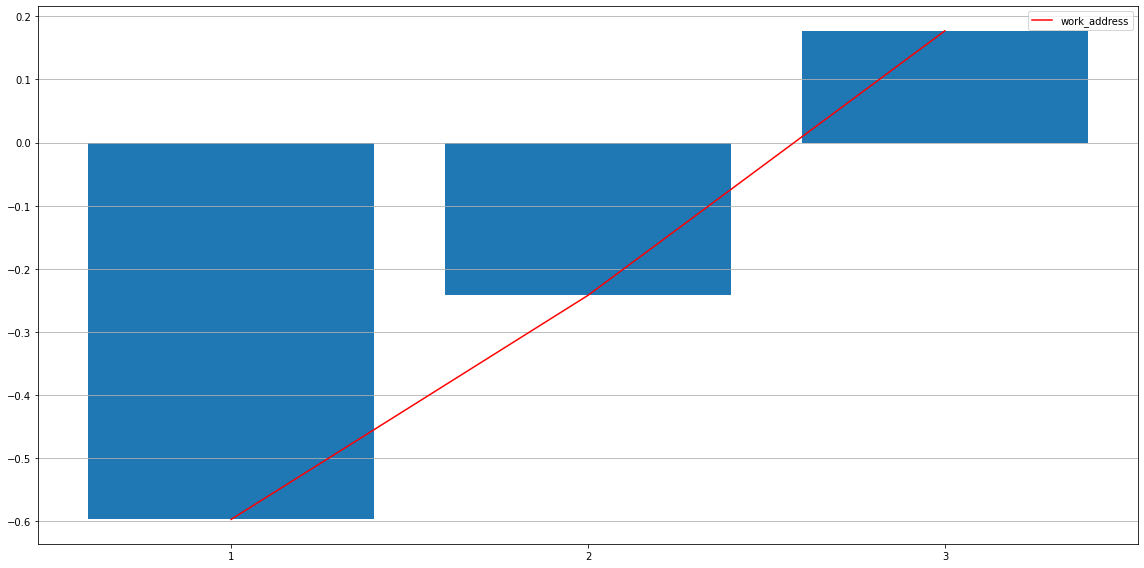

In [47]:
plot_bin(woeDF, 'work_address')

In [48]:
data['home_work_address'] = (data.home_address.astype(str)+data.work_address.astype(str)).astype(int)

In [49]:
data['home_work_address'].value_counts()

23    57609
12    29066
11    11832
13     7790
33     1714
22     1574
21      408
32      121
31       34
Name: home_work_address, dtype: int64

In [50]:
newDF, woeDF = iv_woe(data[data['sample']==1], 'default', bins=10, show_woe=False)
newDF

,Variable,IV
0,score_bki,0.275214
1,sna,0.132047
2,first_time,0.101243
3,home_work_address,0.094265
4,region_rating,0.081816
5,home_address,0.079869
6,education,0.072655
7,work_address,0.067363
8,decline_app_cnt,0.065325
9,foreign_passport,0.048587


In [51]:
woeDF[woeDF.Variable=='home_work_address']

,Variable,Cutoff,N,Events,% of Events,Non-Events,% of Non-Events,WoE,IV
68,home_work_address,11,8034,607,0.064767,7427,0.115278,-0.576542,0.029121
69,home_work_address,12,19391,1969,0.210094,17422,0.270415,-0.252402,0.015225
70,home_work_address,13,5160,451,0.048122,4709,0.073090,-0.417957,0.010436
71,home_work_address,21,276,11,0.001174,265,0.004113,-1.254028,0.003686
72,home_work_address,22,1042,123,0.013124,919,0.014264,-0.083295,0.000095
73,home_work_address,23,38638,6065,0.647140,32573,0.505580,0.246857,0.034945
74,home_work_address,31,24,0,0.000053,24,0.000373,-1.943395,0.000620
75,home_work_address,32,73,10,0.001067,63,0.000978,0.087257,0.000008
76,home_work_address,33,1161,136,0.014511,1025,0.015909,-0.091987,0.000129


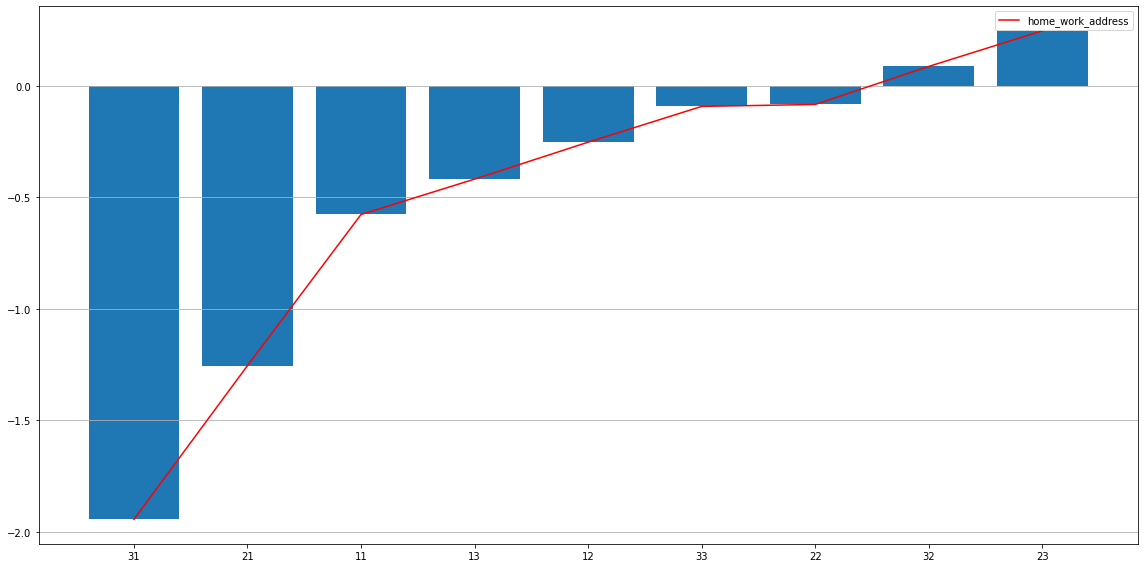

In [52]:
plot_bin(woeDF.sort_values('WoE'), 'home_work_address')

In [53]:
data.drop(['home_address','work_address'], axis=1, inplace=True)

In [54]:
data['good_work_sex'] = (data.good_work.astype(str)+data.sex.astype(str)).astype(int)
newDF, woeDF = iv_woe(data[data['sample']==1], 'default', bins=10, show_woe=False)
newDF

,Variable,IV
0,score_bki,0.275214
1,sna,0.132047
2,first_time,0.101243
3,home_work_address,0.094265
4,region_rating,0.081816
5,education,0.072655
6,decline_app_cnt,0.065325
7,foreign_passport,0.048587
8,bki_request_cnt,0.044567
9,income,0.039744


In [55]:
data.drop(['good_work','sex'], axis=1, inplace=True)

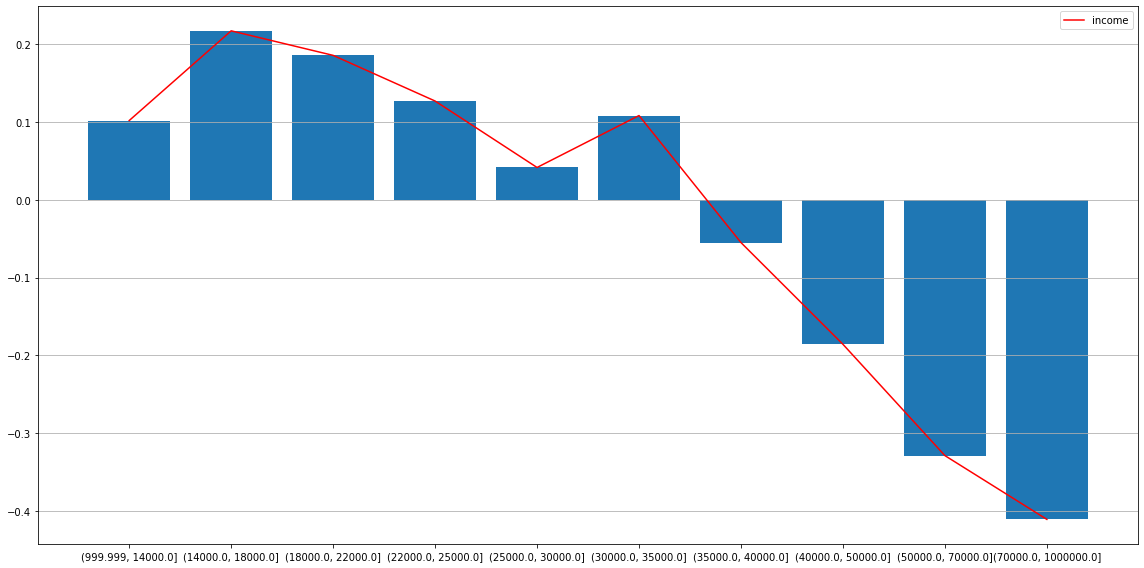

In [56]:
plot_bin(woeDF, 'income')

In [57]:
data['binned_income'] = pd.cut(data.income, [999,22000,35000,40000,70000,1000000])

In [58]:
newDF, woeDF = iv_woe(data[data['sample']==1], 'default', bins=10, show_woe=False)
newDF

,Variable,IV
0,score_bki,0.275214
1,sna,0.132047
2,first_time,0.101243
3,home_work_address,0.094265
4,region_rating,0.081816
5,education,0.072655
6,decline_app_cnt,0.065325
7,foreign_passport,0.048587
8,bki_request_cnt,0.044567
9,income,0.039744


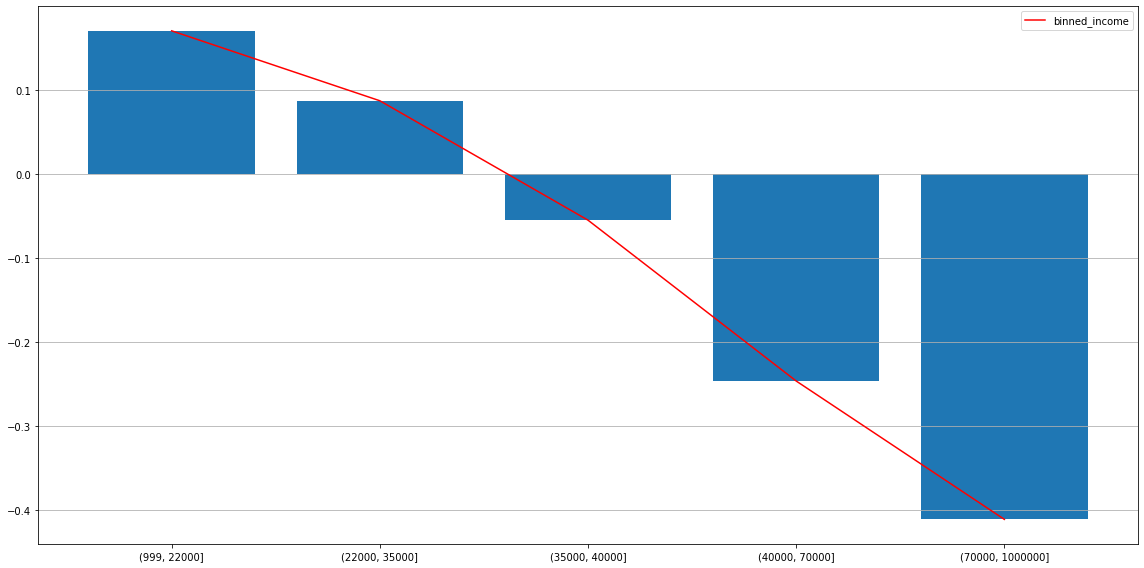

In [59]:
plot_bin(woeDF, 'binned_income')

In [60]:
data.drop('income', axis=1, inplace=True)

<AxesSubplot:>

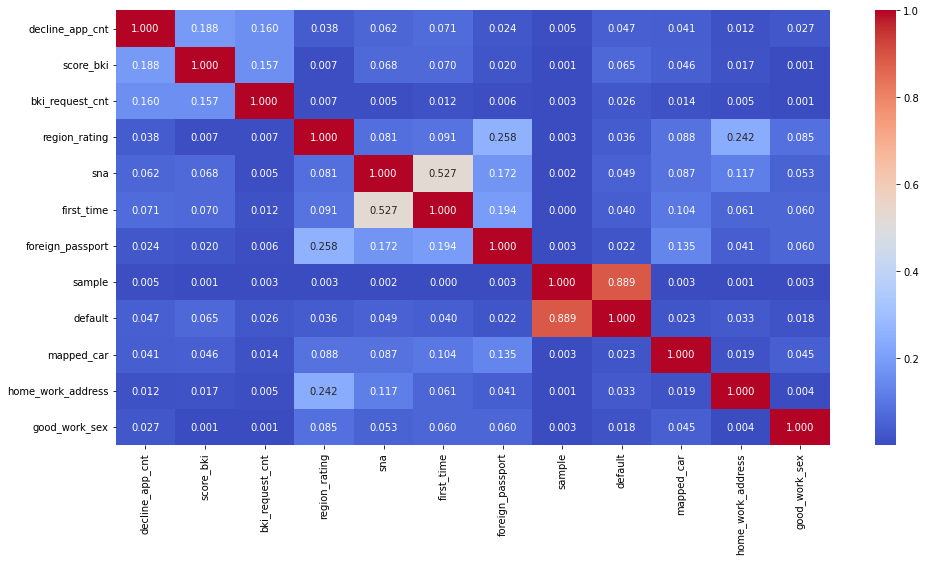

In [61]:
plt.figure(figsize=(16, 8))
sns.heatmap(data.corr().abs(), annot=True, cmap='coolwarm', fmt='.3f', annot_kws={'size':10})

In [62]:
data.groupby(['first_time'])['sna'].value_counts().rename('percentage').reset_index()

,first_time,sna,percentage
0,1,4,10497
1,1,1,3526
2,1,2,2643
3,1,3,1630
4,2,1,8702
5,2,2,4421
6,2,4,2169
7,2,3,1955
8,3,1,33258
9,3,2,7185


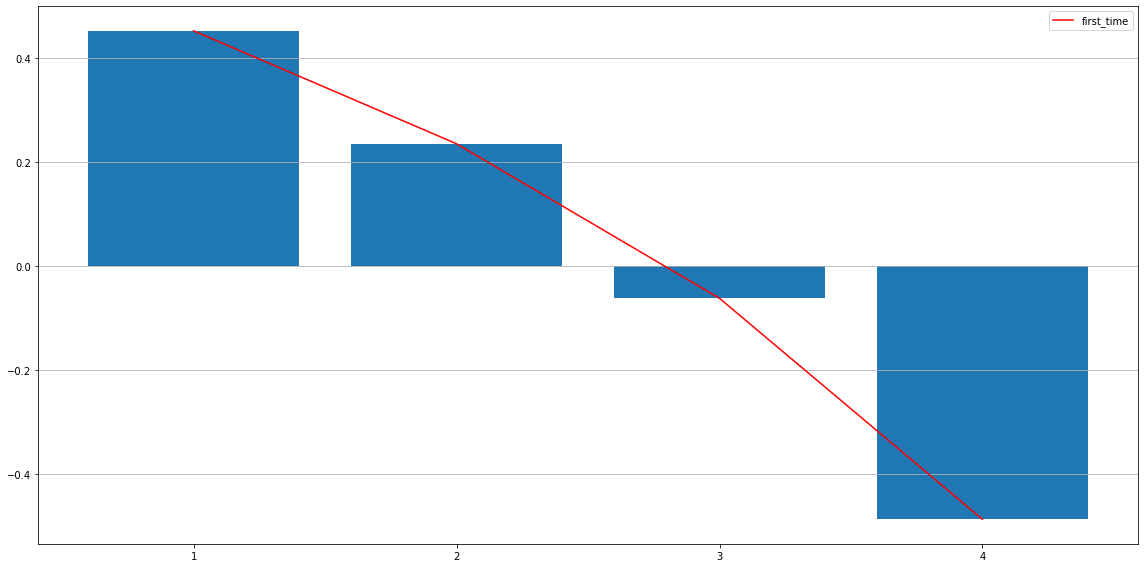

In [63]:
plot_bin(woeDF, 'first_time')

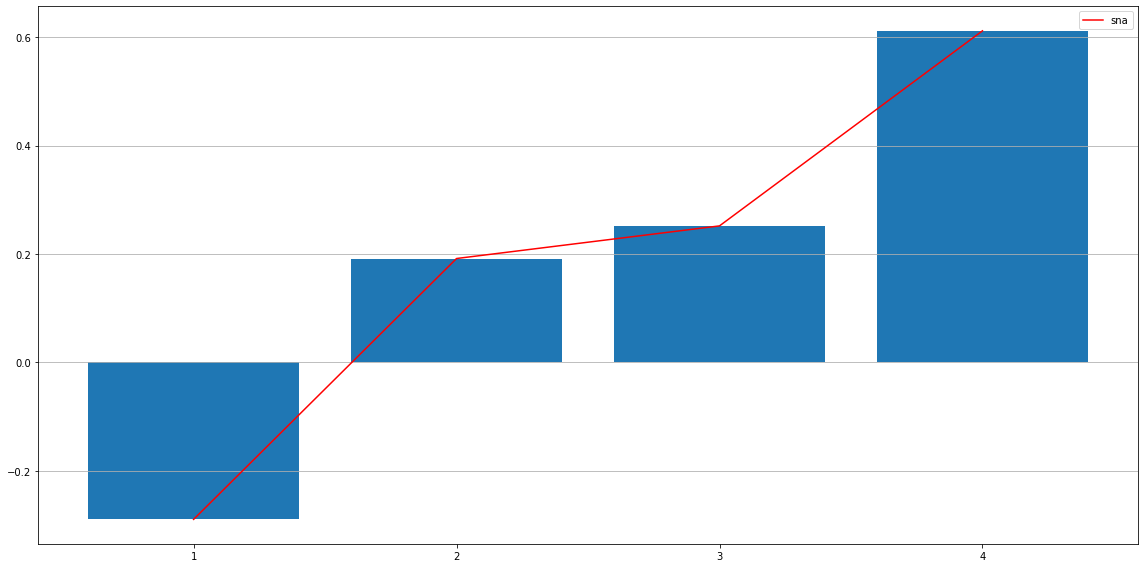

In [64]:
plot_bin(woeDF, 'sna')

In [65]:
data['first_time_sna'] = data.first_time/data.sna

In [66]:
newDF, woeDF = iv_woe(data[data['sample']==1], 'default', bins=10, show_woe=False)
newDF

,Variable,IV
0,score_bki,0.275214
1,first_time_sna,0.170935
2,sna,0.132047
3,first_time,0.101243
4,home_work_address,0.094265
5,region_rating,0.081816
6,education,0.072655
7,decline_app_cnt,0.065325
8,foreign_passport,0.048587
9,bki_request_cnt,0.044567


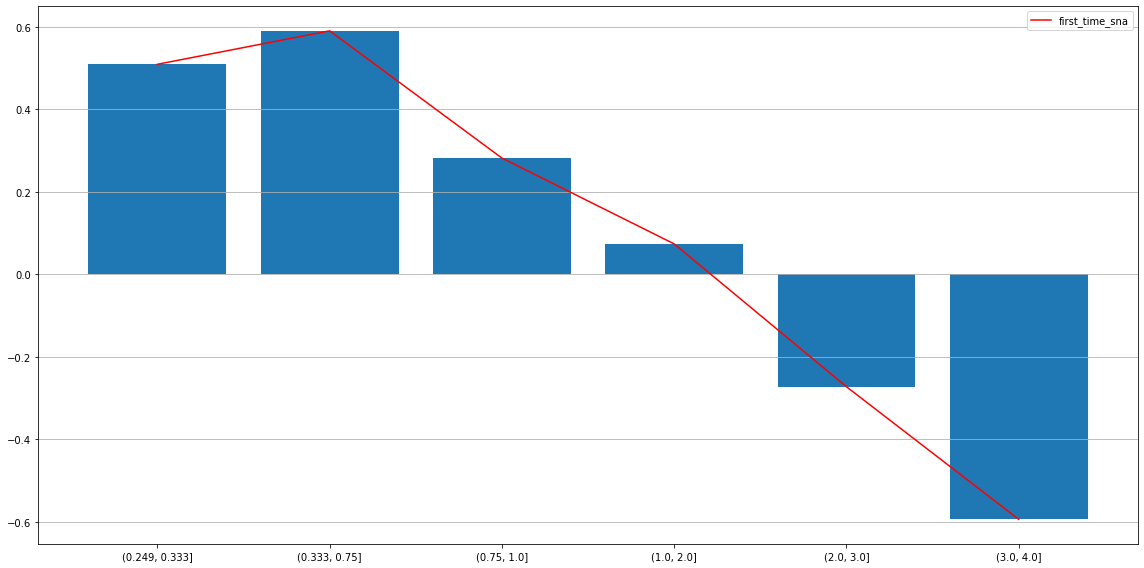

In [67]:
plot_bin(woeDF, 'first_time_sna')

In [68]:
data.drop(['first_time','sna'], axis=1, inplace=True)

In [69]:
data.nunique()

education                 6
decline_app_cnt          24
score_bki            102618
bki_request_cnt          40
region_rating             7
foreign_passport          2
sample                    2
default                   3
binned_age                4
mapped_car                3
home_work_address         9
good_work_sex             4
binned_income             5
first_time_sna           11
dtype: int64

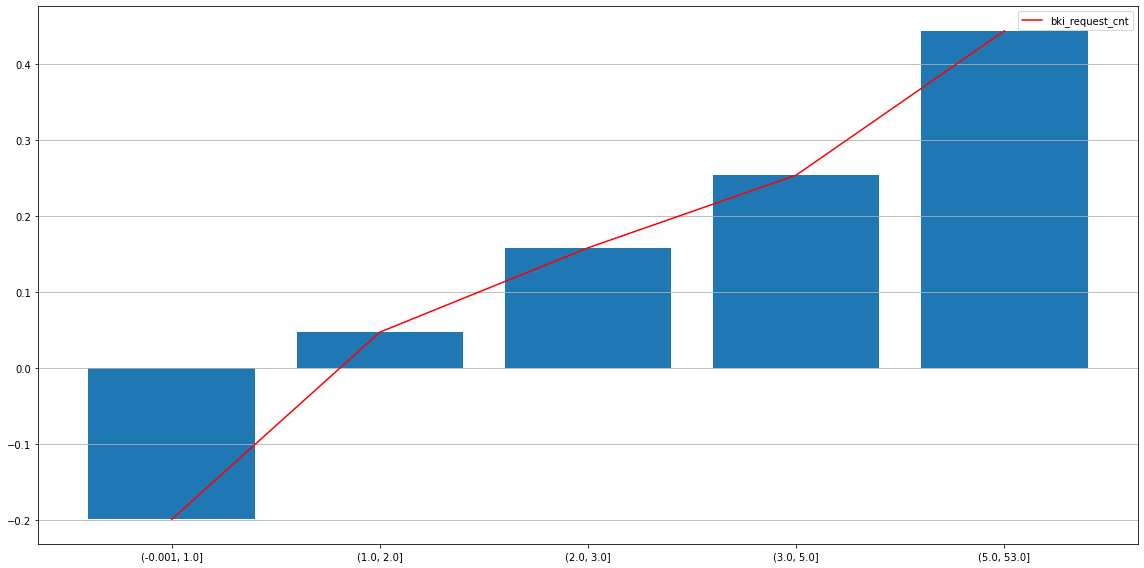

In [70]:
plot_bin(woeDF, 'bki_request_cnt')

In [71]:
data['binned_bki_request_cnt'] = pd.qcut(data['bki_request_cnt'], 10,  duplicates='drop')
data.drop('bki_request_cnt', axis=1, inplace=True)

In [72]:
data['binned_bki_request_cnt'].value_counts()

(-0.001, 1.0]    56203
(1.0, 2.0]       20481
(2.0, 3.0]       13670
(3.0, 5.0]       13366
(5.0, 53.0]       6428
Name: binned_bki_request_cnt, dtype: int64

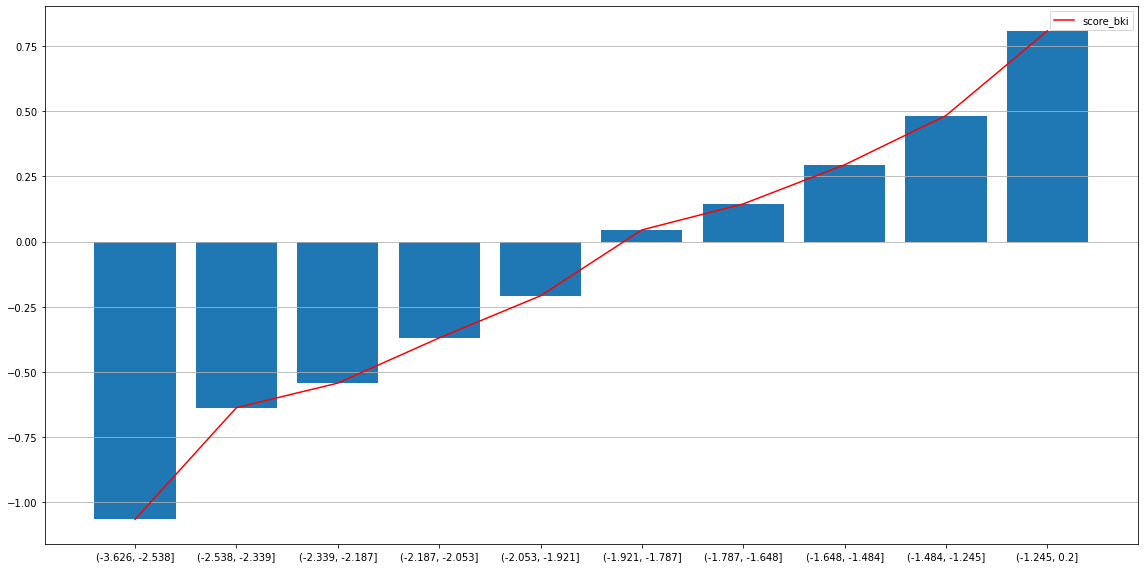

In [73]:
plot_bin(woeDF, 'score_bki')

In [74]:
data['binned_score_bki'] = pd.qcut(data['score_bki'], 10,  duplicates='drop')
data.drop('score_bki', axis=1, inplace=True)

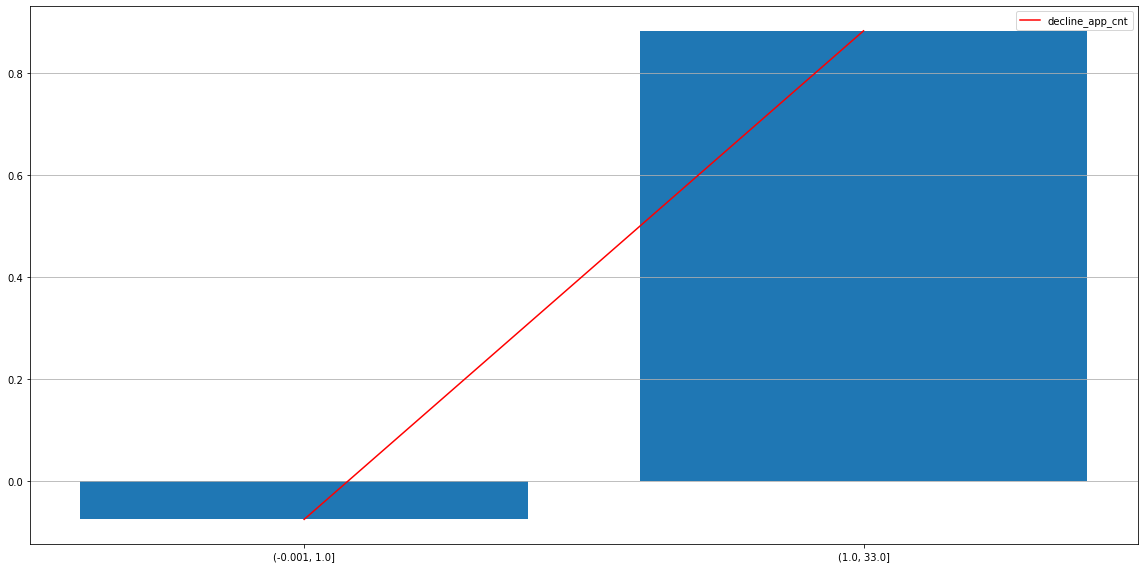

In [75]:
plot_bin(woeDF, 'decline_app_cnt')

In [76]:
woeDF[woeDF.Variable=='decline_app_cnt']

,Variable,Cutoff,N,Events,% of Events,Non-Events,% of Non-Events,WoE,IV
6,decline_app_cnt,"(-0.001, 1.0]",69611,8282,0.883696,61329,0.951915,-0.074362,0.005073
7,decline_app_cnt,"(1.0, 33.0]",4188,1090,0.116304,3098,0.048085,0.883227,0.060252


In [77]:
data.decline_app_cnt.value_counts()

0     91471
1     12500
2      3622
3      1365
4       606
5       255
6       156
7        58
8        37
9        29
10       16
11       10
12        5
13        4
14        3
16        3
21        1
30        1
20        1
19        1
22        1
33        1
15        1
24        1
Name: decline_app_cnt, dtype: int64

In [78]:
data['binned_decline_app_cnt'] = pd.qcut(data['decline_app_cnt'], 10,  duplicates='drop')
data.drop('decline_app_cnt', axis=1, inplace=True)

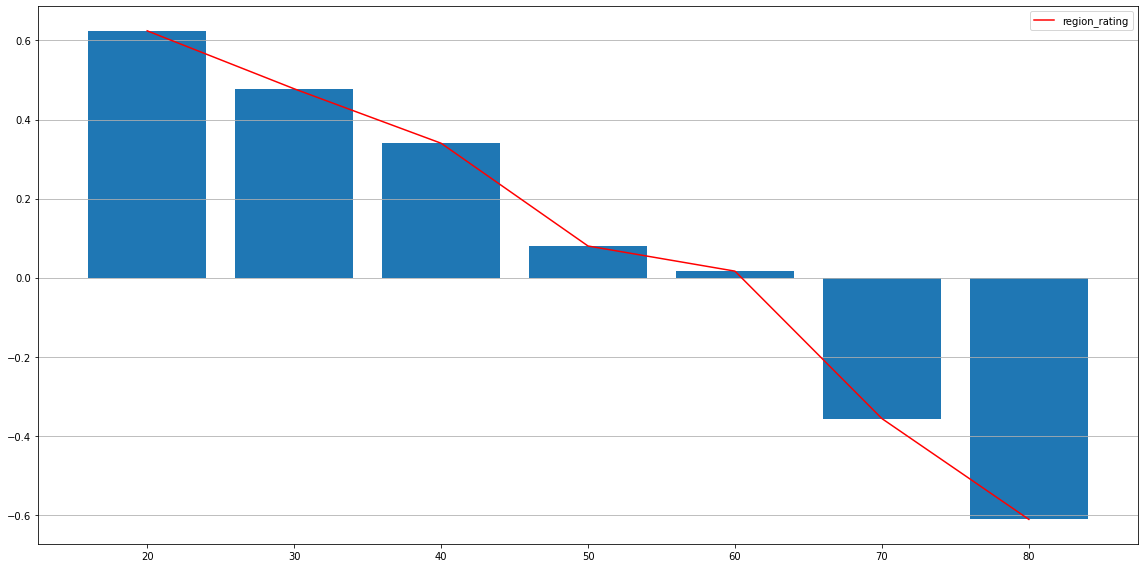

In [79]:
plot_bin(woeDF, 'region_rating')

In [80]:
newDF, woeDF = iv_woe(data[data['sample']==1], 'default', bins=10, show_woe=False)
newDF

,Variable,IV
0,binned_score_bki,0.275668
1,first_time_sna,0.170935
2,home_work_address,0.094265
3,region_rating,0.081816
4,education,0.072655
5,binned_decline_app_cnt,0.065325
6,foreign_passport,0.048587
7,binned_bki_request_cnt,0.044567
8,binned_income,0.037582
9,mapped_car,0.033896


In [81]:
data.nunique()

education                  6
region_rating              7
foreign_passport           2
sample                     2
default                    3
binned_age                 4
mapped_car                 3
home_work_address          9
good_work_sex              4
binned_income              5
first_time_sna            11
binned_bki_request_cnt     5
binned_score_bki          10
binned_decline_app_cnt     2
dtype: int64

In [82]:
data = pd.get_dummies(data)

In [83]:
data.head()

,region_rating,foreign_passport,sample,default,mapped_car,home_work_address,good_work_sex,first_time_sna,education_ACD,education_GRD,...,"binned_score_bki_(-2.339, -2.188]","binned_score_bki_(-2.188, -2.053]","binned_score_bki_(-2.053, -1.921]","binned_score_bki_(-1.921, -1.787]","binned_score_bki_(-1.787, -1.648]","binned_score_bki_(-1.648, -1.481]","binned_score_bki_(-1.481, -1.245]","binned_score_bki_(-1.245, 0.2]","binned_decline_app_cnt_(-0.001, 1.0]","binned_decline_app_cnt_(1.0, 33.0]"
0,50,0,0,-1,2,12,1,4.00,0,1,...,1,0,0,0,0,0,0,0,1,0
1,50,0,0,-1,0,12,0,0.75,0,0,...,0,0,0,0,0,1,0,0,0,1
2,50,1,0,-1,2,12,1,3.00,0,0,...,0,0,0,0,1,0,0,0,1,0
3,40,0,0,-1,0,12,1,3.00,0,0,...,0,0,0,0,0,0,0,0,1,0
4,80,0,0,-1,0,23,0,3.00,0,1,...,0,0,0,0,0,0,0,0,1,0


In [84]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 40 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   region_rating                         110148 non-null  int64  
 1   foreign_passport                      110148 non-null  int64  
 2   sample                                110148 non-null  int64  
 3   default                               110148 non-null  int64  
 4   mapped_car                            110148 non-null  int64  
 5   home_work_address                     110148 non-null  int64  
 6   good_work_sex                         110148 non-null  int64  
 7   first_time_sna                        110148 non-null  float64
 8   education_ACD                         110148 non-null  uint8  
 9   education_GRD                         110148 non-null  uint8  
 10  education_PGR                         110148 non-null  uint8  
 11  

In [85]:
# Помимо отбора по IV добавим рекурсивный поиск оптимального количества переменных методом RFE из sklearn.
from sklearn.feature_selection import RFECV

def RFE_feature_selection(clf_lr, X, y):
    rfecv = RFECV(estimator=clf_lr, step=1, cv=StratifiedKFold(5), verbose=0, scoring='roc_auc')
    rfecv.fit(X, y)

    print("Optimal number of features : %d" % rfecv.n_features_)

    # Plot number of features VS. cross-validation scores
    f, ax = plt.subplots(figsize=(14, 9))
    plt.xlabel("Number of features selected")
    plt.ylabel("Cross validation score (nb of correct classifications)")
    plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
    plt.show()
    mask = rfecv.get_support()
    #X = X.idx[:, mask]
    return mask

Optimal number of features : 38


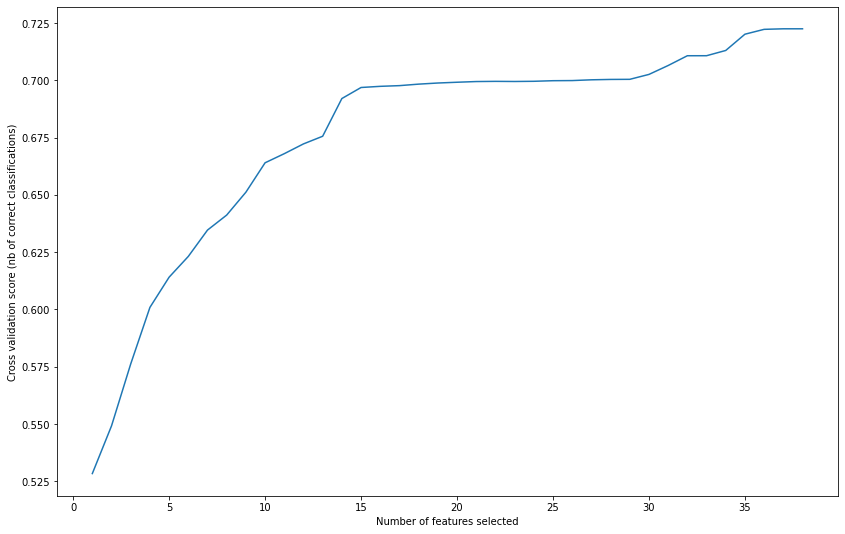

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

In [86]:
clf_lr = LogisticRegression(solver='liblinear')
X = data[data['sample']==1].drop(['sample', 'default'], axis=1)
y = data[data['sample']==1]['default']
mask = RFE_feature_selection(clf_lr, X, y)
mask

In [87]:
X.columns[~mask]

Index([], dtype='object')

Отлично, все получившиеся признаки прибавляют в качестве модели.

## 6. Построение логистической регрессии

In [88]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample', 'default'], axis=1)

y = train_data['default'].values  # наш таргет
X = train_data.drop(['default'], axis=1)

In [89]:
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [90]:
# проверяем
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((59039, 38), (14760, 38), (59039,), (14760,))

In [91]:
lr = LogisticRegression(solver='liblinear')
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
y_pred_proba = lr.predict_proba(X_test)
clf_report = classification_report(y_test, y_pred)
print(clf_report)
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      1.00      0.93     12886
           1       0.34      0.01      0.02      1874

    accuracy                           0.87     14760
   macro avg       0.61      0.50      0.47     14760
weighted avg       0.81      0.87      0.82     14760

[[12853    33]
 [ 1857    17]]


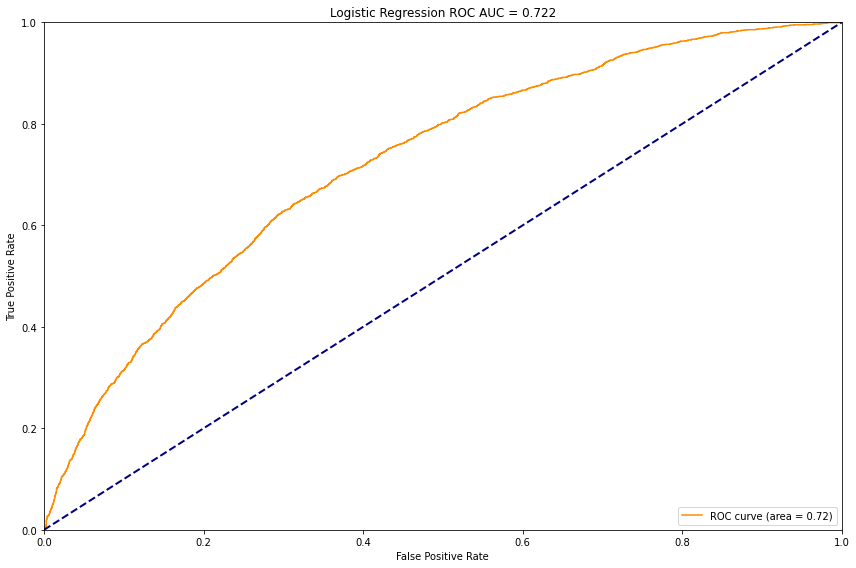

In [92]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:,1])

roc_auc = auc(fpr, tpr)

plt.figure(figsize=(12,8), facecolor='w')
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

In [93]:
# запускаем GridSearch на небольшом кол-ве итераций max_iter=500 и с достаточно большой дельтой останова tol1e-3
# чтобы получить оптимальные параметры модели в первом приближении
from sklearn.model_selection import GridSearchCV

model = LogisticRegression()

iter_ = 500
epsilon_stop = 1e-3

param_grid = [
    {'penalty': ['l1'], 
     'solver': ['liblinear', 'lbfgs'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['l2'], 
     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['none'], 
     'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
]

## model ваша модель логистической регрессии
#gridsearch = GridSearchCV(model, param_grid, scoring='f1', n_jobs=-1, cv=5)
#gridsearch.fit(X_train, y_train)
#model_2 = gridsearch.best_estimator_

##печатаем параметры
#best_parameters = model_2.get_params()
#for param_name in sorted(best_parameters.keys()):
#        print('\t%s: %r' % (param_name, best_parameters[param_name]))

In [94]:
best_parameters = {'C': 1.0,
                   'class_weight': 'balanced',
                   'dual': False,
                   'fit_intercept': True,
                   'intercept_scaling': 1,
                   'l1_ratio': None,
                   'max_iter': 500,
                   'multi_class': 'ovr',
                   'n_jobs': None,
                   'penalty': 'l1',
                   'random_state': None,
                   'solver': 'liblinear',
                   'tol': 0.001,
                   'verbose': 0,
                   'warm_start': False
                  }

In [95]:
lr = LogisticRegression(C=1,
                        #class_weight='balanced',
                        fit_intercept=True,
                        intercept_scaling=10,
                        penalty='l1',
                        solver='liblinear',
                        tol=0.001,
                        verbose=0,
                       )
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
y_pred_proba = lr.predict_proba(X_test)
clf_report = classification_report(y_test, y_pred)
print(clf_report)
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      1.00      0.93     12886
           1       0.34      0.01      0.02      1874

    accuracy                           0.87     14760
   macro avg       0.61      0.50      0.47     14760
weighted avg       0.81      0.87      0.82     14760

[[12853    33]
 [ 1857    17]]


In [96]:
# если качество нас устраивает, обучаем финальную модель на всех обучающи данных
logreg_final = LogisticRegression(C=1,
                        class_weight='balanced',
                        fit_intercept=True,
                        intercept_scaling=10,
                        penalty='l1',
                        solver='liblinear',
                        tol=0.001,
                        verbose=0,)
logreg_final.fit(X, y)

LogisticRegression(C=1, class_weight='balanced', intercept_scaling=10,
                   penalty='l1', solver='liblinear', tol=0.001)

In [97]:
predict_submission = logreg_final.predict(test_data)

In [98]:
sample_submission['default'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,client_id,default
0,74835,0
1,17527,1
2,75683,0
3,26883,0
4,28862,0
5,99881,1
6,26630,1
7,79934,0
8,16605,0
9,105449,0


In [99]:
sample_submission.describe()

,client_id,default
count,36349.000000,36349.000000
mean,54945.647473,0.387796
std,31706.052195,0.487254
min,4.000000,0.000000
25%,27744.000000,0.000000
50%,54657.000000,0.000000
75%,82322.000000,1.000000
max,110148.000000,1.000000


In [100]:
!kaggle competitions submit -c sf-scoring -f submission.csv -m "Message"

# !kaggle competitions submit your-competition-name -f submission.csv -m 'My submission message'

Traceback (most recent call last):
  File "/opt/conda/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/opt/conda/lib/python3.7/site-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/opt/conda/lib/python3.7/site-packages/kaggle/api/kaggle_api_extended.py", line 166, in authenticate
    self.config_file, self.config_dir))
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.
